In [120]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [121]:
def convolve2d(image, kernel):
    kernel_height, kernel_width = kernel.shape
    pad_h = kernel_height // 2
    pad_w = kernel_width // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    output = np.zeros_like(image, dtype=np.float64)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel_height, j:j+kernel_width]
            output[i, j] = np.sum(region * kernel)
    
    return output

In [122]:

sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]])

def lucas_kanade_optical_flow(I1, I2, window_size=5, step=5):
    
    Ix = convolve2d(I1, sobel_x)
    Iy = convolve2d(I1, sobel_y)
    
    It = I2.astype(np.float64) - I1.astype(np.float64)
    
#     plt.subplot(1,3,1)
#     plt.imshow(Ix, cmap='gray')
#     plt.subplot(1,3,2)
#     plt.imshow(Iy, cmap='gray')
#     plt.subplot(1,3,3)
#     plt.imshow(It, cmap='gray')
#     plt.show()
    
    u = np.zeros(I1.shape)
    v = np.zeros(I1.shape)
    
    half_window = window_size // 2
    
    for i in range(half_window, I1.shape[0] - half_window, step):
        for j in range(half_window, I1.shape[1] - half_window, step):
            window_Ix = Ix[i - half_window: i + half_window + 1, j - half_window: j + half_window + 1]
            window_Iy = Iy[i - half_window: i + half_window + 1, j - half_window: j + half_window + 1]
            window_It = It[i - half_window: i + half_window + 1, j - half_window: j + half_window + 1]
            
#             if (i == 2 and j == 2) or (i == 7 and j == 7):
#                 plt.subplot(1,3,1)
#                 plt.imshow(window_Ix, cmap='gray')
#                 print(It)
#                 plt.subplot(1,3,2)
#                 plt.imshow(window_Iy, cmap='gray')
#                 plt.subplot(1,3,3)
#                 plt.imshow(window_It, cmap='gray')
#                 plt.show()
#                 print(It[27: 37, 27: 37])
                
            window_Ix_flatten = window_Ix.flatten()
            window_Iy_flatten = window_Iy.flatten()
            window_It_flatten = window_It.flatten()
            
#             if (i == 2 and j == 2) or (i == 7 and j == 7):
#                 print(window_Ix)
#                 print(window_Ix_flatten)
                
            A = np.vstack((window_Ix_flatten, window_Iy_flatten))
                
#             if (i == 2 and j == 2) or (i == 7 and j == 7):
#                 print("A is ", A)
#                 plt.imshow(A, cmap = "gray")
#                 plt.show()
                
            A = A.T
            b = -window_It_flatten
            
            nu, _, _, _ = np.linalg.lstsq(A, b, rcond = False)
            
            u[i, j] = nu[0]
            v[i, j] = nu[1]
    plt.title("U - optical flow vector in x direction")
    plt.imshow(u, cmap = "gray")
    plt.show()
    plt.title("V - optical flow vector in y direction")
    plt.imshow(v, cmap = "gray")
    plt.show()
    return u, v
    

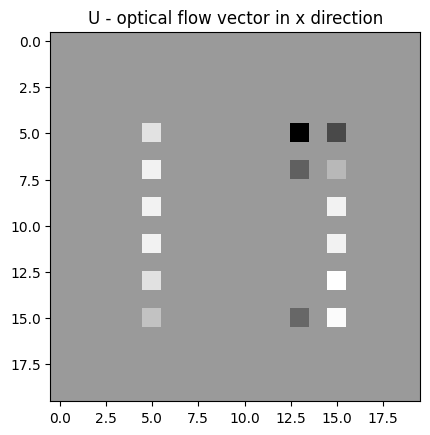

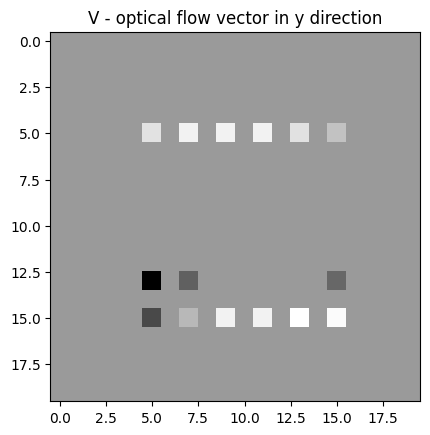

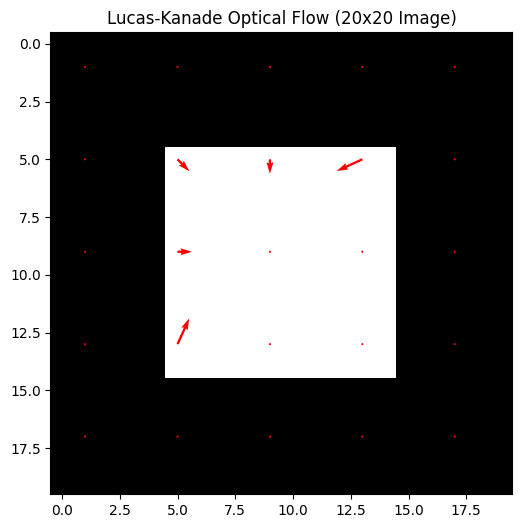

In [124]:
# --- Create Synthetic Frames for Demonstration ---
u, v = lucas_kanade_optical_flow(I1, I2, window_size=3, step=2)

# --- Prepare a Grid for Visualization ---
# We know our loop runs from index 1 to I1.shape[0]-1, so we use that range.
grid_x = np.arange(1, I1.shape[1]-1, 4)
grid_y = np.arange(1, I1.shape[0]-1, 4)
X, Y = np.meshgrid(grid_x, grid_y)
u_sampled = u[1:I1.shape[0]-1:4, 1:I1.shape[1]-1:4]
v_sampled = v[1:I1.shape[0]-1:4, 1:I1.shape[1]-1:4]

# Option: Multiply u and v to make the arrows longer (if necessary)
u_display = 5 * u_sampled
v_display = 5 * v_sampled

# --- Visualize the Optical Flow ---
plt.figure(figsize=(6,6))
plt.imshow(I1, cmap='gray')
plt.quiver(X, Y, u_display, v_display, color='red', angles='xy',
           scale_units='xy', scale=1, width=0.005, headwidth=3)
plt.title("Lucas-Kanade Optical Flow (20x20 Image)")
plt.show()



In [125]:

# Optionally, print the grid and sampled values for debugging:
print("Grid X:\n", X)
print("Grid Y:\n", Y)
print("Sampled u:\n", u_sampled)
print("Sampled v:\n", v_sampled)

Grid X:
 [[ 1  5  9 13 17]
 [ 1  5  9 13 17]
 [ 1  5  9 13 17]
 [ 1  5  9 13 17]
 [ 1  5  9 13 17]]
Grid Y:
 [[ 1  1  1  1  1]
 [ 5  5  5  5  5]
 [ 9  9  9  9  9]
 [13 13 13 13 13]
 [17 17 17 17 17]]
Sampled u:
 [[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.10294118  0.         -0.222334    0.        ]
 [ 0.          0.125       0.          0.          0.        ]
 [ 0.          0.10160966  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
Sampled v:
 [[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.10294118  0.125       0.10160966  0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.         -0.222334    0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]


In [73]:
# Define matrix A and vector b
A = np.array([[1, 1],
              [1, 2],
              [1, 3]])
b = np.array([1, 2, 2])

# Compute least squares solution
x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

print("Solution x:", x)
print("Residuals:", residuals)
print("Rank of A:", rank)
print("Singular values of A:", s)

Solution x: [0.66666667 0.5       ]
Residuals: [0.16666667]
Rank of A: 2
Singular values of A: [4.07914333 0.60049122]


In [74]:
# Ax = b
# A.T * A * x = A.T * b

# linalg = linear algebra, lstsq = leastt square, rcond = Relative condition